### Facultad de Ciencias Exactas, Ingeniería y Agrimensura - UNR
## Tenicatura Universitaria en Inteligencia Artificial.


# Trabajo Práctico Final: Procesamiento de Lenguaje Natural.

- **Pace, Bruno. Legajo: P-5295/7.**

Docentes:
 - Manson, Juan Pablo.
 - Geary, Alan.
 - Sollberger, Dolores.
 - Ferrucci, Costantino.

Fecha de Entrega: 15 de diciembre de 2024.


In [1]:
# Redis graph
%%capture
!pip install redis redisgraph
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes


import redis
from redisgraph import Graph, Node, Edge
import matplotlib.pyplot as plt
import networkx as nx

# Selenium web scrapping
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install selenium

!apt-get install -y xvfb
!pip install pyvirtualdisplay

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

import os
os.environ["PATH"] += ":/usr/bin/chromedriver"

# Visualización
import matplotlib.pyplot as plt
import networkx as nx



# Base de Datos de Grafo

## Web scrapping
Se obtiene información a través de Web Scrapping con Selenium.
Se tiene la siguiente información:
- Diseñadores.
- Artistas.
- Familia de Juegos.
- Mecanismos.
- Empresas que lo publicaron.
- Categorias.

In [2]:
url_grafo: str = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
title: str = 'Rajas Of The Ganges'

In [3]:
def buscar_credito(data: str) -> tuple[dict[str, list[str]], dict[str,list[str]]]:
    """
    Retorna una tupla de diccionarios que contienen el(los) nombre(s) y el link(s) correspondiente(s)

    Args:
      data: str = el nombre del dato a buscar

    Returns:
      name_dict: dict[str, list[str]] = diccionario con los nombres.
      link_dict: dict[str, list[str]] = diccionario con los links.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    driver = webdriver.Chrome(service=Service(), options=chrome_options)
    driver.get(url_grafo)

    name_dict: dict[str, list[str]] = {f"{data}_nombre": []}
    link_dict: dict[str, list[str]] = {f"{data}_link": []}

    elements = driver.find_elements(By.XPATH, f'//a[contains(@ng-href, "/boardgame{data}/")]')

    if elements:
        for element in elements:
            name_dict[f"{data}_nombre"].append(element.text)
            link_dict[f"{data}_link"].append(element.get_attribute('href'))
    else:
        print(f"No se encontraron elementos para {data}")

    driver.quit()

    return name_dict, link_dict

data_designer: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("designer")
data_artist: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("artist")
data_family: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("family")
data_mechanic: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("mechanic")
data_publisher: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("publisher")
data_categories: tuple[dict[str, list[str]], dict[str,list[str]]] = buscar_credito("category")

In [4]:
data_categories[0]

{'category_nombre': ['Dice', 'Economic', 'Renaissance', 'Territory Building']}

## Creación de BBDD de Grafos
Se utiliza Redis, por su simple implementación con Colab.

In [5]:
redis_client = redis.Redis(host='localhost', port=6379)

In [6]:
def define_relation(label: str) -> str:
  """
  Define la relación entre el nodo titulo y el nodo que se quiere relacionar

  Args:
    label: str = el label del nodo que se quiere relacionar

  Returns:
    str = el label de la relación
  """
  if label == "Designer":
    return "Designed_by"
  elif label == "Artist":
    return "Created_by"
  elif label == "Family":
    return "Similar_to"
  elif label == "Mechanic":
    return "Mechanic"
  elif label == "Published_by":
    return "Published by"
  elif label == "Category":
    return "Category"
  return None

In [7]:
def crear_nodos_with_edges(graph: Graph, data: dict[str, list[str]], main_node: Node) -> None:
    """
    Dado un diccionario con datos, crea los nodos correspondientes en un grafo
    de redis y añade las relaciones correspondientes.

    Args:
        graph: Redis graph instance.
        data: Dictionary containing names as lists under specific keys.
        main_node: The main node to relate new nodes with.

    Returns:
        None
    """
    if not data:
        print("Diccionario vacío")
        return

    for key, names in data[0].items():
        label = key.split("_")[0].capitalize()
        relation = define_relation(label)

        if not relation:
            print(f"Relación no definida para el label: {label}")
            continue

        for name in names:
            print(f'Creando nodo con nombre: {name} y label: {label}')
            node = Node(label=label, properties={"name": name})
            graph.add_node(node)

            print(f'Añadiendo relación: {relation}')
            edge = Edge(main_node, relation, node)
            edge.relattion_type = relation
            graph.add_edge(edge)

    print("Nodos y relaciones creados exitosamente.")
    return None

In [8]:
graph = Graph('creditos', redis_client)

def create_all_nodes(graph: Graph) -> None:
  """
  Crea los nodos del grafo.
  Args:
    graph: grafo de redis.

  Returns:
    None
  """
  main_node = Node(label='title', properties={"name": title})
  graph.add_node(main_node)
  crear_nodos_with_edges(graph, data_designer, main_node)
  crear_nodos_with_edges(graph, data_artist, main_node)
  crear_nodos_with_edges(graph, data_family, main_node)
  crear_nodos_with_edges(graph, data_mechanic, main_node)
  crear_nodos_with_edges(graph, data_publisher, main_node)
  graph.commit()
  return None

create_all_nodes(graph)

Creando nodo con nombre: Inka Brand y label: Designer
Añadiendo relación: Designed_by
Creando nodo con nombre: Markus Brand y label: Designer
Añadiendo relación: Designed_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Dennis Lohausen y label: Artist
Añadiendo relación: Created_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Admin: Better Description Needed! y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Country: India y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Tabletopia y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Yucata y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Game: Rajas of the Ganges y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Mechanism: Dice Drafting y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Religious: Hinduism y label: Fa

In [9]:
def get_all_nodes(graph: Graph) -> list[dict]:
    """
    Devuelve todos los nodos del grafo

    Args:
        graph: grafo de redis

    Returns:
        Lista de diccionarios con id, label y properties de cada nodo.
    """
    query = "MATCH (n) RETURN n"
    result = graph.query(query)
    nodes: list = []

    for record in result.result_set:
        node = record[0]
        node_data = {
            "id": node.id,
            "label": node.label,
            "properties": node.properties
        }
        nodes.append(node_data)

    return nodes

all_nodes = get_all_nodes(graph)
for node in all_nodes:
    print(node)

{'id': 0, 'label': 'title', 'properties': {'name': 'Rajas Of The Ganges'}}
{'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}
{'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}
{'id': 3, 'label': 'Artist', 'properties': {'name': 'Dennis Lohausen'}}
{'id': 4, 'label': 'Family', 'properties': {'name': 'Admin: Better Description Needed!'}}
{'id': 5, 'label': 'Family', 'properties': {'name': 'Country: India'}}
{'id': 6, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Tabletopia'}}
{'id': 7, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Yucata'}}
{'id': 8, 'label': 'Family', 'properties': {'name': 'Game: Rajas of the Ganges'}}
{'id': 9, 'label': 'Family', 'properties': {'name': 'Mechanism: Dice Drafting'}}
{'id': 10, 'label': 'Family', 'properties': {'name': 'Religious: Hinduism'}}
{'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}
{'id': 12, 'label': 'Mechanic', 'properties': {'name': 'Dice 

 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Designed_by]->()
 record 2: (:Designer{name:"Inka Brand"})
()-[:Designed_by]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Designed_by]->()
 record 2: (:Designer{name:"Markus Brand"})
()-[:Designed_by]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Created_by]->()
 record 2: (:Artist{name:"Dennis Lohausen"})
()-[:Created_by]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Similar_to]->()
 record 2: (:Family{name:"Admin: Better Description Needed!"})
()-[:Similar_to]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Similar_to]->()
 record 2: (:Family{name:"Country: India"})
()-[:Similar_to]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Similar_to]->()
 record 2: (:Family{name:"Digital Implementations: Tabletopia"})
()-[:Similar_to]->()
 record 0: (:title{name:"Rajas Of The Ganges"})
 record 1: ()-[:Similar_to]->()
 record

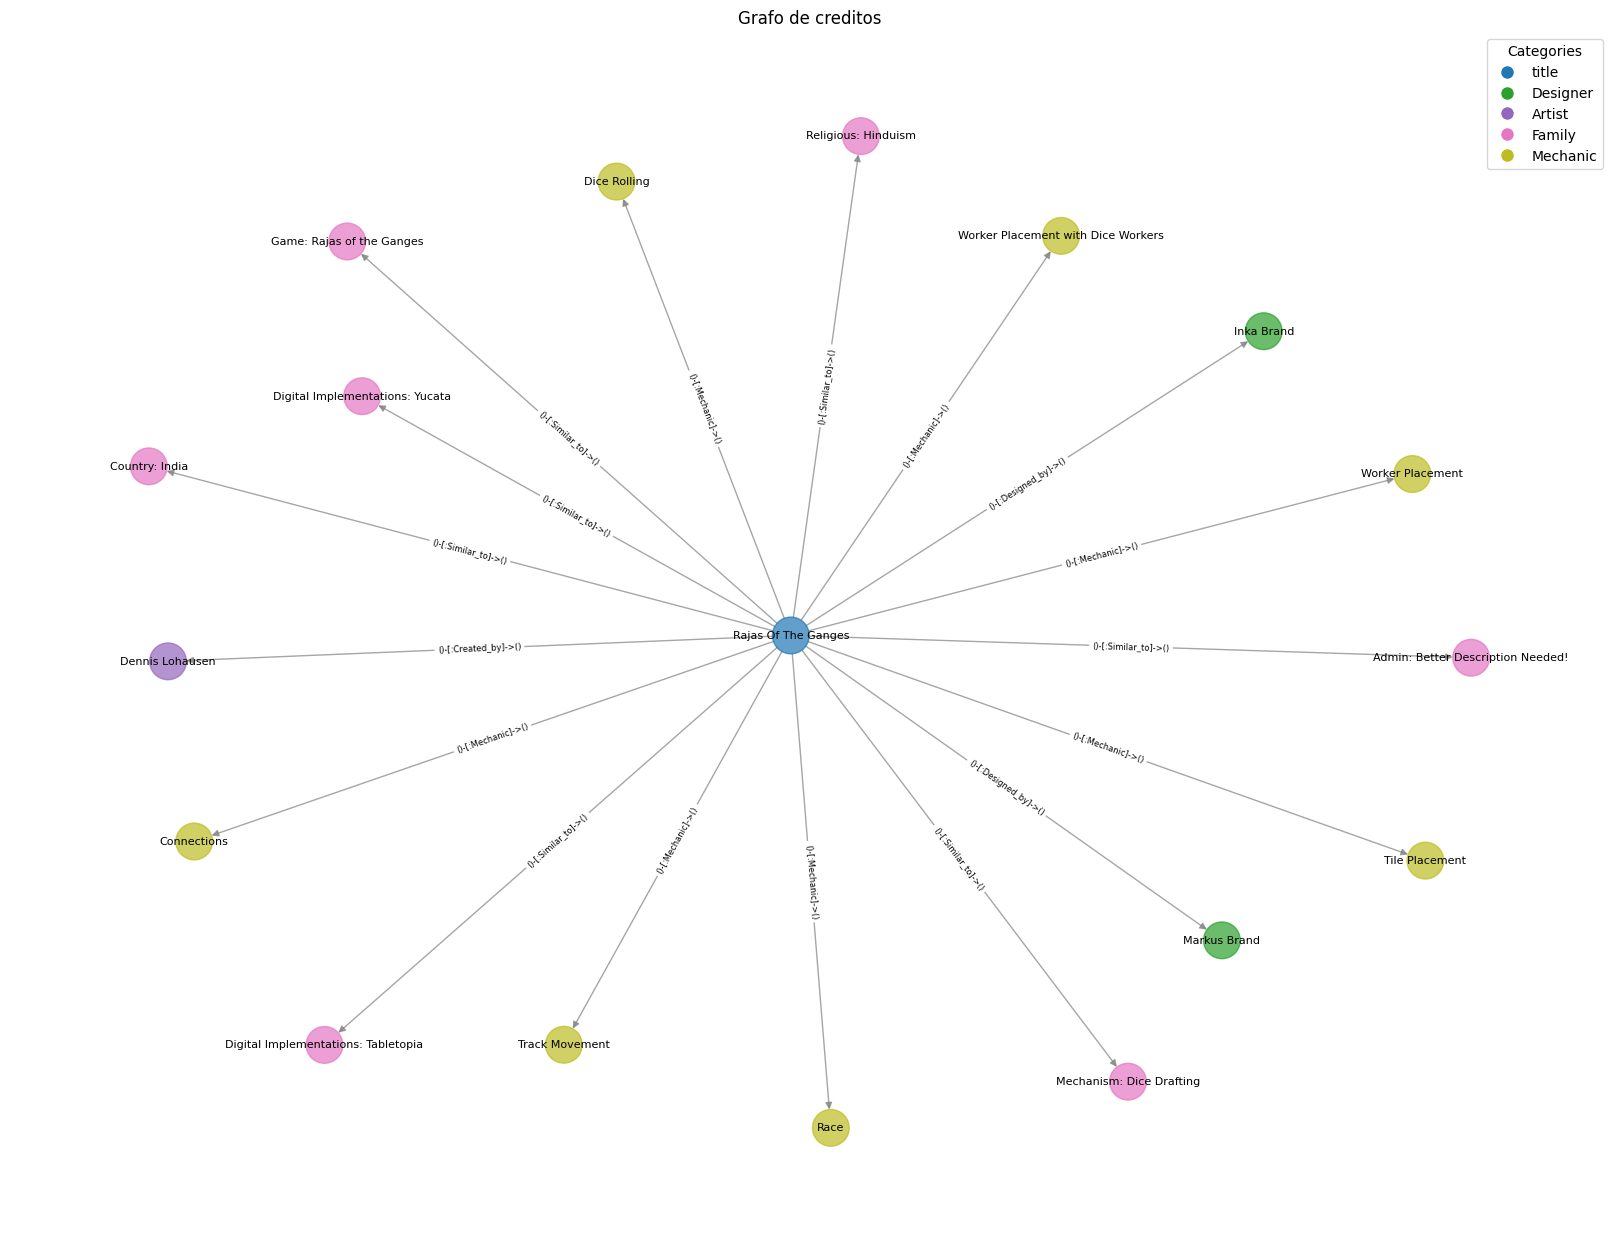

In [10]:
def plot_graph(graph: Graph) -> None:
    """
    Plot de un grafo de redis con sus relaciones

    Args:
        graph: grafo de redis

    Returns:
        None
    """
    nx_graph = nx.DiGraph()

    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_name = node.properties.get("name", f"Node {node_id}")
        nx_graph.add_node(node_id, label=node_label, name=node_name, category=node_label)

    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        print(f' record 0: {record[0]}')
        print(f' record 1: {record[1]}')
        print(f' record 2: {record[2]}')
        src = record[0].id
        dest = record[2].id
        relationship = record[1]
        print(relationship)
        nx_graph.add_edge(src, dest, label=relationship)

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(nx_graph, k=0.5)

    categories = nx.get_node_attributes(nx_graph, 'category')
    unique_categories = set(categories.values())
    node_colors = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    node_color_list = [node_colors[categories[node]] for node in nx_graph.nodes()]

    nx.draw(
        nx_graph, pos,
        with_labels=False,
        node_size=700,
        node_color=node_color_list,
        edge_color='gray',
        alpha=0.7
    )

    node_labels = {node: data['name'] for node, data in nx_graph.nodes(data=True)}
    nx.draw_networkx_labels(nx_graph, pos, labels=node_labels, font_size=8, font_color='black')

    edge_labels = nx.get_edge_attributes(nx_graph, "label")
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat)
                     for cat, color in node_colors.items()]
    plt.legend(handles=legend_labels, loc='best', title='Categories')

    plt.title("Grafo de creditos")
    plt.show()

plot_graph(graph)

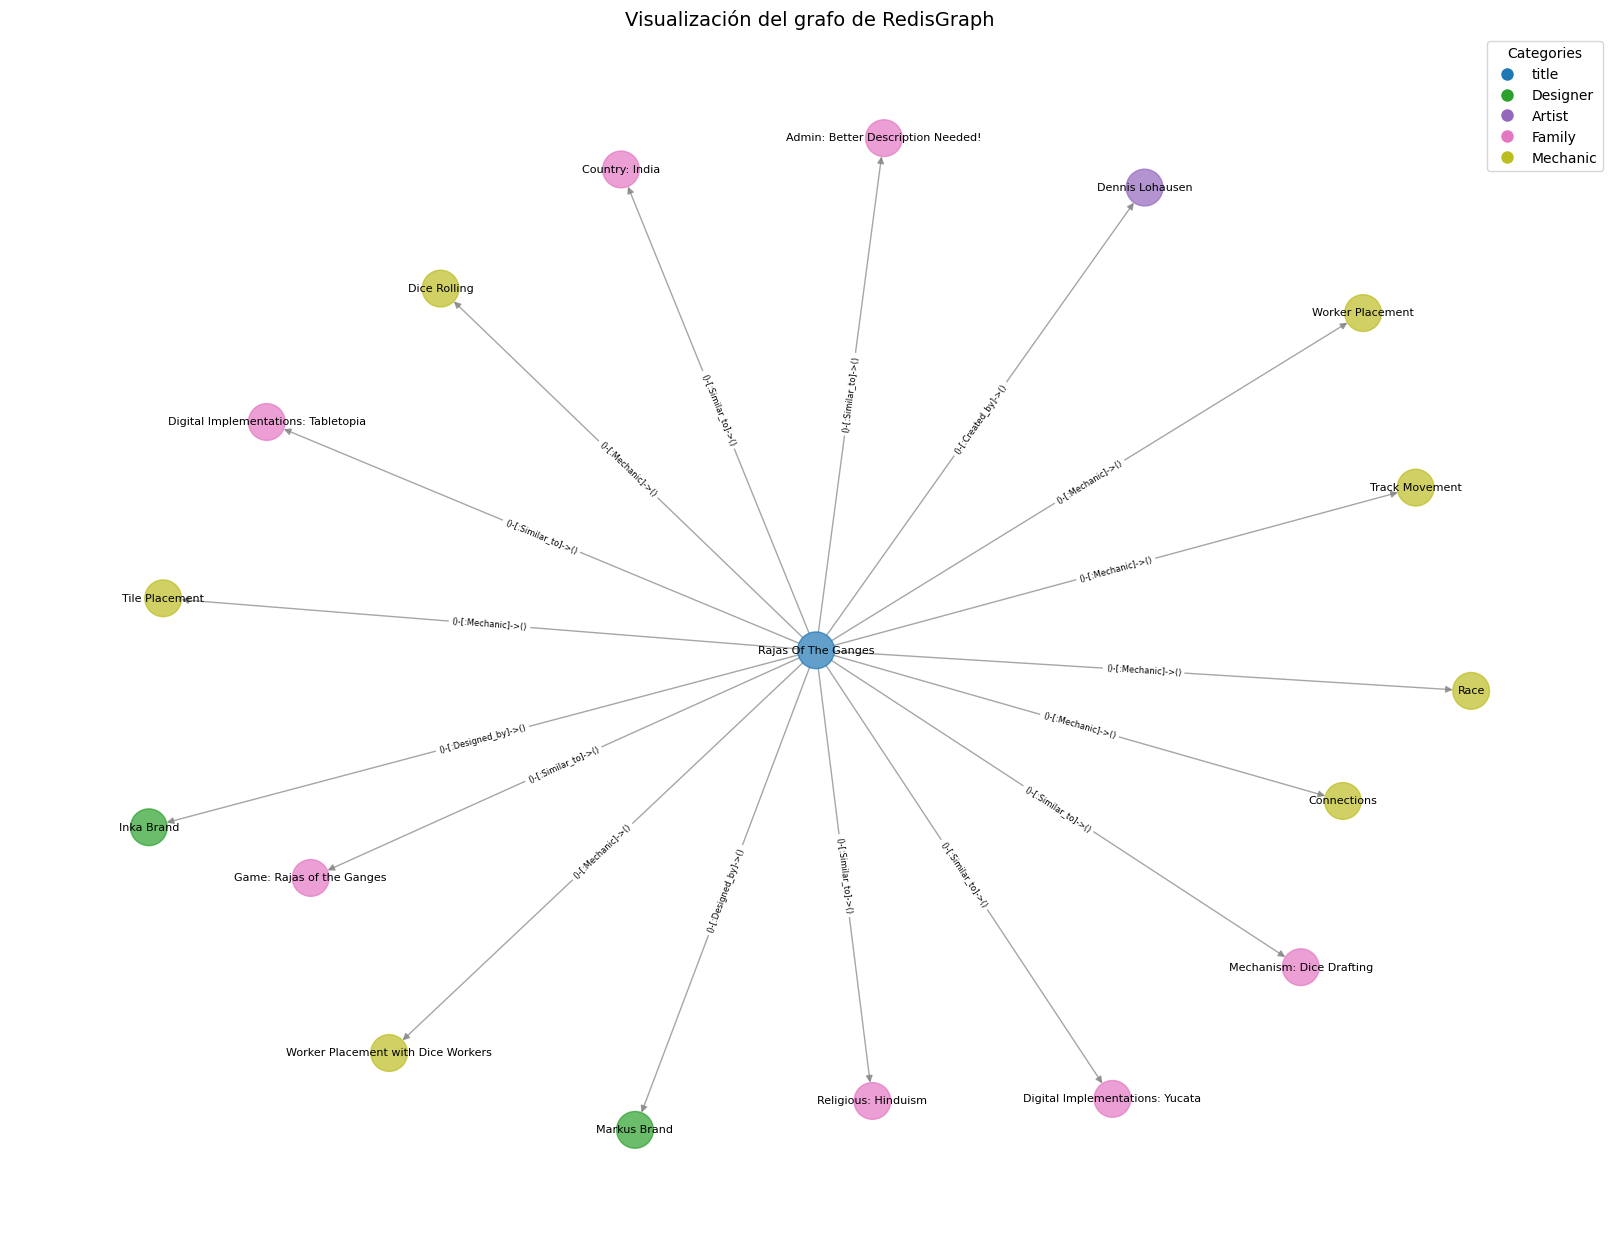

In [16]:
def plot_graph(graph: Graph) -> None:
    """
    Plot de un grafo de redis con sus relaciones

    Args:
        graph: grafo de redis

    Returns:
        None
    """
    nx_graph = nx.DiGraph()

    #node_query = "MATCH (n) RETURN n"
    node_query = """MATCH (a)-[r:Designed_by]->(b) RETURN a.name, b.name, type(r)"""
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_name = node.properties.get("name", f"Node {node_id}")
        nx_graph.add_node(node_id, label=node_label, name=node_name, category=node_label)


    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        #print(f' record 0: {record[0]}')
        #print(f' record 1: {record[1]}')
        #print(f' record 2: {record[2]}')
        src = record[0].id
        dest = record[2].id
        relationship = record[1]
        #print(relationship)
        nx_graph.add_edge(src, dest, label=relationship)

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(nx_graph, k=0.5)

    categories = nx.get_node_attributes(nx_graph, 'category')
    unique_categories = set(categories.values())
    node_colors = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    node_color_list = [node_colors[categories[node]] for node in nx_graph.nodes()]

    nx.draw(
        nx_graph, pos,
        with_labels=False,
        node_size=700,
        node_color=node_color_list,
        edge_color='gray',
        alpha=0.7
    )

    node_labels = {node: data['name'] for node, data in nx_graph.nodes(data=True)}
    nx.draw_networkx_labels(nx_graph, pos, labels=node_labels, font_size=8, font_color='black')

    edge_labels = nx.get_edge_attributes(nx_graph, "label")
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat)
                     for cat, color in node_colors.items()]
    plt.legend(handles=legend_labels, loc='best', title='Categories')

    plt.title("Visualización del grafo de RedisGraph", fontsize=14)
    plt.show()

# Llamar a la función para graficar
plot_graph(graph)
